In [1]:
import numpy as np
import pImpactR as impact
from copy import deepcopy as copy
input_fname = 'test_IOTA.in'
np.set_printoptions(formatter={'float': lambda x: format(x, '1.3E')})

### 1. read InputFile

In [2]:
beam, lattice = impact.readInputFile(input_fname)

reading ImpactZ input file (test_IOTA.in)
  : mpi task info .............................done
  : simulation control parameters .............done
  : space charge field solver, mesh info ......done
  : dist-type,restart,subcycle,#of state ......done
  : Multiple Charge State info ................done
  : particle distribution info ................done
  : beam reference orbit info .................done
  : converting impact dist to twiss param......done
  : lattice info ..............................done


In [27]:
lattice[1]


             length: 1.8 [m]
           n_sckick: 36 [1]
              n_map: 5 [1]
         strength_t: 0.4
 transverse_scale_c: 0.01
       tune_advance: 0.3034496449165134
        pipe_radius: 10.0 [m]
               type: 'nonlinear_insert'

### 2. generate particles

In [3]:
testP = 0.0
sig = 0.002
k=0
q_m = beam.multi_charge.q_m[0]
pTest = []
nx = 30
for i in range(-nx,nx+1):
    for j in range(-nx,nx+1):
        x=i*sig/nx
        y=j*sig/nx
        if x**2+y**2<=sig**2 :
            k+=1
            pTest.append([x,0.0,y,0.0,0.0,0.0,q_m,0.0,k])

pTest = np.array(pTest)
ke = beam.kinetic_energy
mass = beam.mass
freq = beam.frequency
impact.writeParticleData(pTest, ke, mass, freq)
print(len(pTest))

2813


### 3. adjust lattice

In [4]:
lattice[0].turns = 1024

In [5]:
from math import ceil

for i in range(len(lattice)):
    if 'length' in lattice[i].keys():
        lattice[i].n_sckick = ceil(lattice[i].length*20)
        if lattice[i].type in ['nonlinear_insert','dipole']:
            lattice[i].n_map = 5
        else:
            lattice[i].n_map = 2

In [6]:
for i in range(len(lattice)-1,0,-1):
    if lattice[i].type in ['write_raw_ptcl','-8']:
        lattice.pop(i)

##### element types in IOTA

In [7]:
types=[]
for i in range(len(lattice)):
    types.append(lattice[i].type)

types = set(types)
print(types)

{'quad', 'dipole', 'loop_through_lattice', 'nonlinear_insert', 'drift', 'multipole_thin'}


##### backward lattice

In [8]:
nElem = len(lattice)

latticeB = copy(lattice[::-1])
latticeB.pop()
for i in range(len(latticeB)):
    if 'length' in latticeB[i]:
        latticeB[i].length = -latticeB[i].length
    if 'KL_sext' in latticeB[i]:
        latticeB[i].KL_sext = -latticeB[i].KL_sext
    if latticeB[i].type == 'dipole':
        latticeB[i].bending_angle = -latticeB[i].bending_angle
        latticeB[i].fringe_field_integration = -latticeB[i].fringe_field_integration
        
lattice = lattice + latticeB

### 4. run

In [9]:
beam.current = 0.0
beam.nCore_y = 2
beam.nCore_z = 2
beam.n_particles = len(pTest)

impact.writeInputFile(beam,lattice)
#impact.run(4)

input error <- sum(beam.multi_charge.n_particles) not qual to beam.n_particles
  ... enforcing  beam.multi_charge.n_particles[0] to beam.n_particles
input error <- beam.multi_charge.current[0] not qual to beam.current
  ... enforcing  beam.multi_charge.current[0] to beam.current


0

In [10]:
pDataIn = impact.readParticleData(111110,ke,mass,freq)
pDataOut= impact.readParticleData(111111,ke,mass,freq)

In [11]:
print(pDataOut[5,:6]-pDataIn[5,:6])

[-2.290E-14 -7.364E-15 -4.442E-16 -7.002E-16 -6.705E-12 0.000E+00]


### 5. DA

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
diff = pDataIn[:,:6]- pDataOut[:,:6]
Xdiff = np.sqrt(diff[:,0]**2 +diff[:,2]**2)
Pdiff = np.sqrt(diff[:,1]**2 +diff[:,3]**2)
Adiff = Xdiff/np.mean(Xdiff)+Pdiff/np.mean(Pdiff)

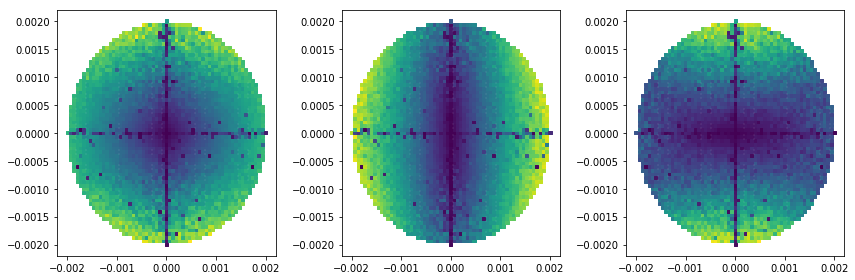

In [22]:
xmax = np.max( [np.real(pDataIn[:,0]), np.real(pDataIn[:,2])])
plt.figure(figsize=[12,4])
plt.subplot(1,3,1)
plt.scatter(pDataIn[:,0],pDataIn[:,2],c=Adiff,s=10,marker='s')
plt.xlim(-xmax*1.1,xmax*1.1)
plt.ylim(-xmax*1.1,xmax*1.1)
plt.subplot(1,3,2)
plt.scatter(pDataIn[:,0],pDataIn[:,2],c=Xdiff,s=10,marker='s')
plt.xlim(-xmax*1.1,xmax*1.1)
plt.ylim(-xmax*1.1,xmax*1.1)
plt.subplot(1,3,3)
plt.scatter(pDataIn[:,0],pDataIn[:,2],c=Pdiff,s=10,marker='s')
plt.xlim(-xmax*1.1,xmax*1.1)
plt.ylim(-xmax*1.1,xmax*1.1)
plt.tight_layout()

In [24]:
diff[0,:]

array([2.285E-14, 7.337E-15, -1.504E-18, 1.616E-18, 6.695E-12, 0.000E+00])